# Absolute Speed Map

In [1]:
import intake
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cartopy.feature as cft
import glob

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44629,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:41239,Total threads: 1
Dashboard: /proxy/38541/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:39033,


In [3]:
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [4]:
uo_C = pancontrol01.search(variable="uo", frequency="1mon").to_dask()
vo_C = pancontrol01.search(variable="vo", frequency="1mon").to_dask()
uo_MW = pantrial01.search(variable="uo", frequency="1mon").to_dask()
vo_MW = pantrial01.search(variable="vo", frequency="1mon").to_dask()

In [5]:
uC = uo_C.uo.sel(z_l=slice('0','500')).mean(dim='z_l').sel(time=slice('2001-01','2010-01')).mean(dim='time')
vC = vo_C.vo.sel(z_l=slice('0','500')).mean(dim='z_l').sel(time=slice('2001-01','2010-01')).mean(dim='time')
uMW = uo_MW.uo.sel(z_l=slice('0','500')).mean(dim='z_l').sel(time=slice('2001-01','2010-01')).mean(dim='time')
vMW = vo_MW.vo.sel(z_l=slice('0','500')).mean(dim='z_l').sel(time=slice('2001-01','2010-01')).mean(dim='time')

In [6]:
cont_n = xr.merge([uC,vC])
cont_n= cont_n.isel(xq = slice(1, None), yq = slice(1, None))
pert_n = xr.merge([uMW,vMW])
pert_n= pert_n.isel(xq = slice(1, None), yq = slice(1, None))

In [7]:
path_to_ocean_static_MW = Path('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output021/20010701.ocean_static.nc')
ocean_static_MW = xr.open_dataset(path_to_ocean_static_MW)

In [8]:
ocean_static_MW = ocean_static_MW.sel(xq = pert_n['xq'], xh = pert_n['xh'], yq = pert_n['yq'], yh = pert_n['yh'])

grid_MW = xgcm.Grid(ocean_static_MW, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}},
                                   periodic = ['X'])

In [9]:
path_to_ocean_static_C = Path('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

In [10]:
ocean_static_C = ocean_static_C.sel(xq = pert_n['xq'], xh = pert_n['xh'], yq = pert_n['yq'], yh = pert_n['yh'])

grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}},
                                   periodic = ['X'])

In [11]:
uC_int = grid_C.interp(cont_n['uo'], 'X')
vC_int = grid_C.interp(cont_n['vo'], 'Y')
uMW_int = grid_MW.interp(pert_n['uo'], 'X')
vMW_int = grid_MW.interp(pert_n['vo'], 'Y')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [12]:
abs_C = np.sqrt(uC_int**2 + vC_int**2)
abs_MW = np.sqrt(uMW_int**2 + vMW_int**2)

In [13]:
abs_anom = abs_MW - abs_C
abs_anom = abs_anom.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [14]:
data_fixed = pancontrol01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()

In [15]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [16]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [17]:
depth = data_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

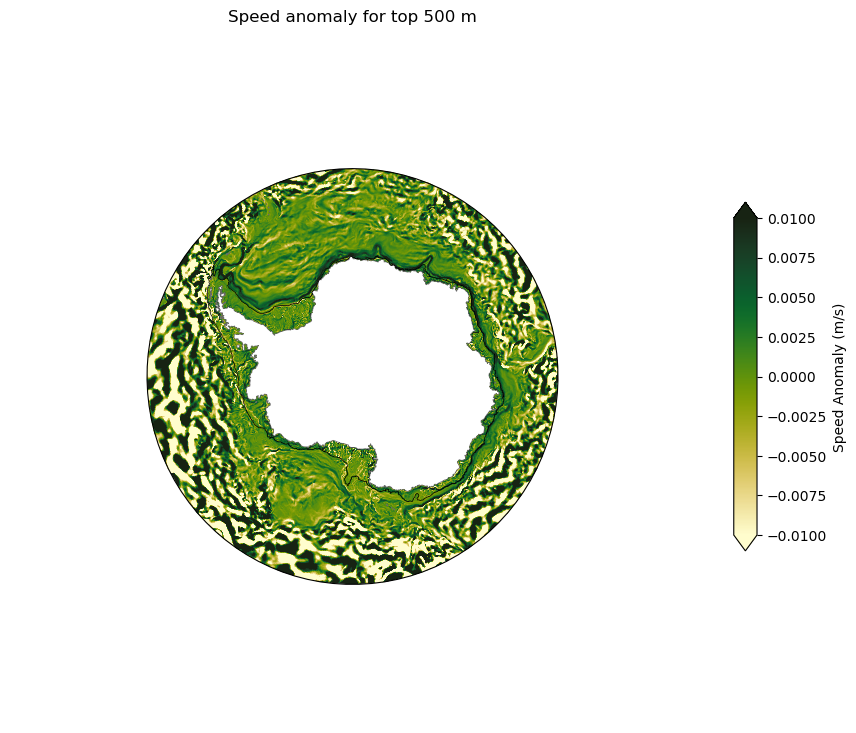

In [19]:
plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.3
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'black', linewidths=0.5,transform = ccrs.PlateCarree())

abs_anom.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.01,
    vmax=0.01,
    extend="both",
    cmap=cm.cm.speed, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Speed Anomaly (m/s)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Speed anomaly for top 500 m");

Text(0.5, 1.0, 'Speed anomaly for top 500 m')

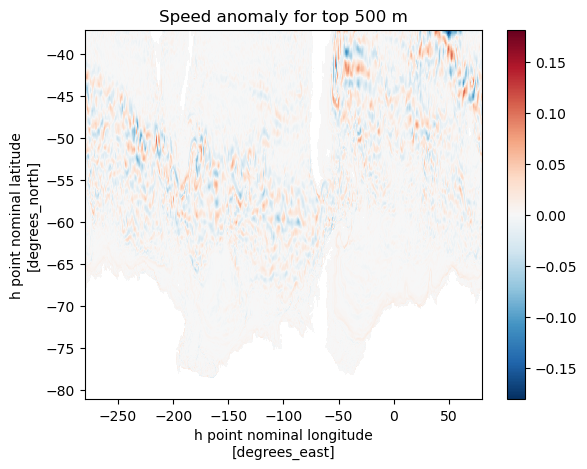

In [31]:
abs_anom.plot()
plt.title("Speed anomaly for top 500 m")